In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopandas as gpd
from geodatasets import get_path
from matplotlib.colors import LinearSegmentedColormap

In [2]:
grid_info_df = pd.read_csv('grid_info.csv')
air_quality_df = pd.read_csv('air_quality_processed.csv')

In [3]:
def extract_data_at_time(time_stamp):
    return air_quality_df[air_quality_df['time_stamp'] == time_stamp]

In [4]:
def create_grid_matrix_by_df(air_quality_at_time):
    max_row = max([int(code.split('@')[0]) for code in grid_info_df['grid_code']])
    max_col = max([int(code.split('@')[1]) for code in grid_info_df['grid_code']])

    grid_matrix = [[None for _ in range(max_col + 1)] for _ in range(max_row + 1)]

    for index, row in grid_info_df.iterrows():
        grid_code = row['grid_code']
        row_index = int(grid_code.split('@')[0])
        col_index = int(grid_code.split('@')[1])
        
        if row['has_sensor']:
            sensor_list = eval(row['sensor_list'])
            max_aqi = None
            for sensor in sensor_list:
                sensor_data = air_quality_at_time[air_quality_at_time['sensor_index'] == sensor]
                if not sensor_data.empty:
                    max_sensor_aqi = sensor_data['pm2.5_aqi'].max()
                    if max_aqi is None or max_sensor_aqi > max_aqi:
                        max_aqi = max_sensor_aqi
            grid_matrix[row_index][col_index] = max_aqi
    
    return grid_matrix

Draw picture function.

In [5]:
path_to_file = get_path('nybb')
nybb = gpd.read_file(path_to_file)
manhattan_boundary = nybb[nybb.BoroName == 'Manhattan'].geometry.values[0]
manhattan_boundary_gdf = gpd.GeoDataFrame(geometry=[manhattan_boundary], crs="EPSG:2263")
manhattan_boundary_gdf = manhattan_boundary_gdf.to_crs(epsg=4326)
manhattan_boundary_geo = manhattan_boundary_gdf.geometry.values[0]

In [6]:
def plot_interpolated_grid(interpolate_method, time_stamp=1705413600):
    grid_matrix = create_grid_matrix_by_df(extract_data_at_time(time_stamp))
    interpolated_matrix = interpolate_method(grid_matrix)

    colors = [(0, 'green'), (0.1667, 'yellow'), (0.3333, 'orange'), (0.5, 'red'), (0.6667, 'purple'), (1, (48/255, 25/255, 52/255))]
    cmap = LinearSegmentedColormap.from_list('aqi_cmap', colors, N=256)
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    cell_size = grid_info_df['max_lon'][0] - grid_info_df['min_lon'][0]
    
    for _, row in grid_info_df.iterrows():
        min_lon, max_lon = row['min_lon'], row['max_lon']
        min_lat, max_lat = row['min_lat'], row['max_lat']
        grid_code = row['grid_code']
        row_index = int(grid_code.split('@')[0])
        col_index = int(grid_code.split('@')[1])
        
        if interpolated_matrix[row_index][col_index] is not None:
            aqi_value = interpolated_matrix[row_index][col_index]
            aqi_value_ratio = min(aqi_value / 300, 1)
            color = cmap(aqi_value_ratio)
        else:
            color = 'green'
        
        rect = plt.Rectangle((min_lon, min_lat), cell_size, cell_size, edgecolor='white', facecolor=color, linewidth=0.3)
        ax.add_patch(rect)
        
        if row['has_sensor']:    
            plt.text((min_lon + max_lon) / 2, (min_lat + max_lat) / 2, '*', ha='center', va='center', fontsize=10, color='white', fontweight='bold')
    
    manhattan_boundary_gdf.boundary.plot(ax=ax, color='blue', linewidth=2)
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Predicted AQI Map by ({interpolate_method.__name__})')
    
    plt.show()

Experiment function: Pretend some of the sensors are not there and use the records of other sensors to predict them by interpolation.

In [7]:
def experiment(interpolate, test_count=200, test_rate=0.2):
    error_records = []

    time_stamps = air_quality_df['time_stamp'].unique()
    if len(time_stamps) > test_count:
        time_stamps = np.random.choice(time_stamps, test_count, replace=False)

    for time_stamp in time_stamps:
        air_quality_at_time = extract_data_at_time(time_stamp)

        train_df, test_df = train_test_split(air_quality_at_time, test_size=test_rate)
        grid_matrix = create_grid_matrix_by_df(train_df)
        interpolated_matrix = interpolate(grid_matrix)

        for _, test_row in test_df.iterrows():
            sensor_index = test_row['sensor_index']
            real_value = test_row['pm2.5_aqi']
            for index, row in grid_info_df.iterrows():
                grid_code = row['grid_code']
                row_index = int(grid_code.split('@')[0])
                col_index = int(grid_code.split('@')[1])

                if sensor_index in eval(row['sensor_list']):
                    predicted_value = interpolated_matrix[row_index][col_index]
                    error = predicted_value - real_value if predicted_value is not None else None
                    error_records.append({
                        'time_stamp': time_stamp,
                        'sensor_index': sensor_index,
                        'error': error
                    })
                    break

    error_df = pd.DataFrame(error_records)
    return error_df

Cubic Spline

In [8]:
from scipy.interpolate import griddata, NearestNDInterpolator

In [9]:
def cubic_spline_interpolation(data):
    data = np.array(data, dtype=np.float64)

    rows, cols = data.shape

    x = np.arange(rows)
    y = np.arange(cols)
    grid_x, grid_y = np.meshgrid(x, y, indexing='ij')
    
    known_points = ~np.isnan(data)
    points = np.array([(i, j) for i in range(rows) for j in range(cols) if known_points[i, j]])
    values = data[known_points]

    if len(points) < rows * cols * 0.1:
        nearest_interp = NearestNDInterpolator(points, values)
        data = nearest_interp(grid_x, grid_y)
        known_points = ~np.isnan(data)
        points = np.array([(i, j) for i in range(rows) for j in range(cols) if known_points[i, j]])
        values = data[known_points]

    interpolated_data = griddata(points, values, (grid_x, grid_y), method='cubic')

    nearest_interp = NearestNDInterpolator(points, values)
    interpolated_data = np.where(np.isnan(interpolated_data), nearest_interp(grid_x, grid_y), interpolated_data)
    
    interpolated_data[interpolated_data < 0] = 0

    return interpolated_data.tolist()

In [10]:
values = [
    [None, None, None],
    [4.0, None, 6.0],
    [None, 8.0, 9.0]
]

In [11]:
filled_values = cubic_spline_interpolation(values)
print(filled_values)

[[4.0, 4.0, 6.0], [4.0, 5.000000053907369, 6.0], [4.0, 8.0, 9.0]]


In [12]:
cubic_spline_error_df = experiment(cubic_spline_interpolation)
cubic_spline_error_df.head(10)

,time_stamp,sensor_index,error
0,1702310400,174933,-0.456250
1,1702310400,175987,1.350000
2,1702310400,188661,-13.458333
3,1702310400,182243,-0.431250
4,1702310400,144554,9.491667
5,1702310400,178413,-20.493750
6,1702310400,202015,11.881250
7,1702310400,178729,5.216667
8,1702310400,92171,-9.829167
9,1702310400,49363,5.491667


In [13]:
cubic_spline_error_df['error'].std()

44.81158510687515

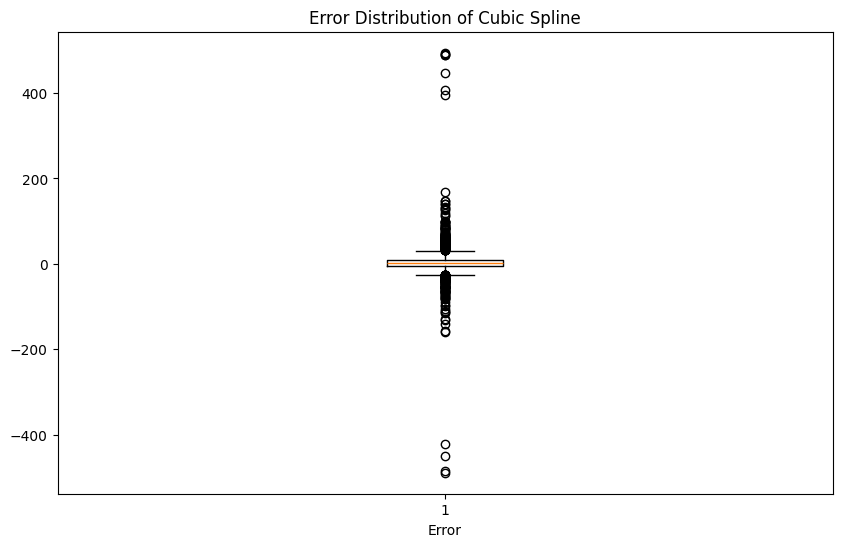

In [14]:
plt.figure(figsize=(10, 6))
plt.boxplot(cubic_spline_error_df['error'])
plt.title('Error Distribution of Cubic Spline')
plt.xlabel('Error')
plt.show()

According to the graph, we can see that the distribution of errors is quite concentrated. It is some extreme values that increase the standard error. 

In [15]:
def get_quantile_table(error_df):
    quantiles = [0.03, 0.10, 0.25, 0.50, 0.75, 0.90, 0.97]
    quantile_values = error_df['error'].quantile(quantiles)
    return pd.DataFrame({'Quantile': quantiles, 'Value': quantile_values})

In [16]:
get_quantile_table(cubic_spline_error_df)

,Quantile,Value
0.03,0.03,-46.786936
0.10,0.10,-16.125000
0.25,0.25,-4.110417
0.50,0.50,1.422917
0.75,0.75,9.995833
0.90,0.90,29.285417
0.97,0.97,63.285813


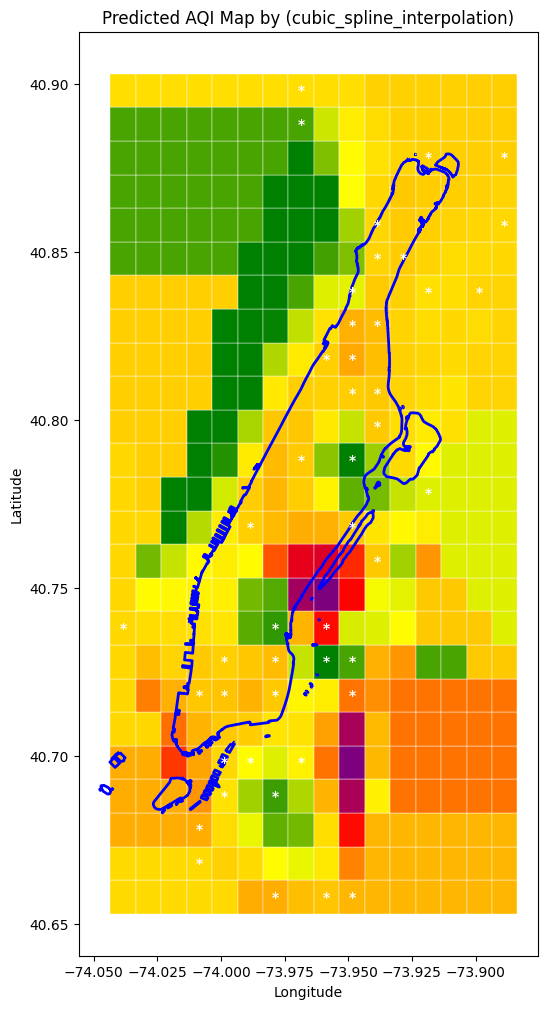

In [17]:
plot_interpolated_grid(cubic_spline_interpolation)

If not using cubic spline, just use nearest neighbor interpolation.

In [18]:
def nearest_neighbor_interpolation(data):
    data = np.array(data, dtype=np.float64)

    rows, cols = data.shape

    x = np.arange(rows)
    y = np.arange(cols)
    grid_x, grid_y = np.meshgrid(x, y, indexing='ij')
    
    known_points = ~np.isnan(data)
    points = np.array([(i, j) for i in range(rows) for j in range(cols) if known_points[i, j]])
    values = data[known_points]
    
    nearest_interp = NearestNDInterpolator(points, values)
    interpolated_data = nearest_interp(grid_x, grid_y)
    
    interpolated_data[interpolated_data < 0] = 0

    return interpolated_data.tolist()

In [19]:
filled_values = nearest_neighbor_interpolation(values)
print(filled_values)

[[4.0, 4.0, 6.0], [4.0, 4.0, 6.0], [4.0, 8.0, 9.0]]


In [20]:
nearest_neighbor_error_df = experiment(nearest_neighbor_interpolation)
nearest_neighbor_error_df['error'].std()

51.65655984774752

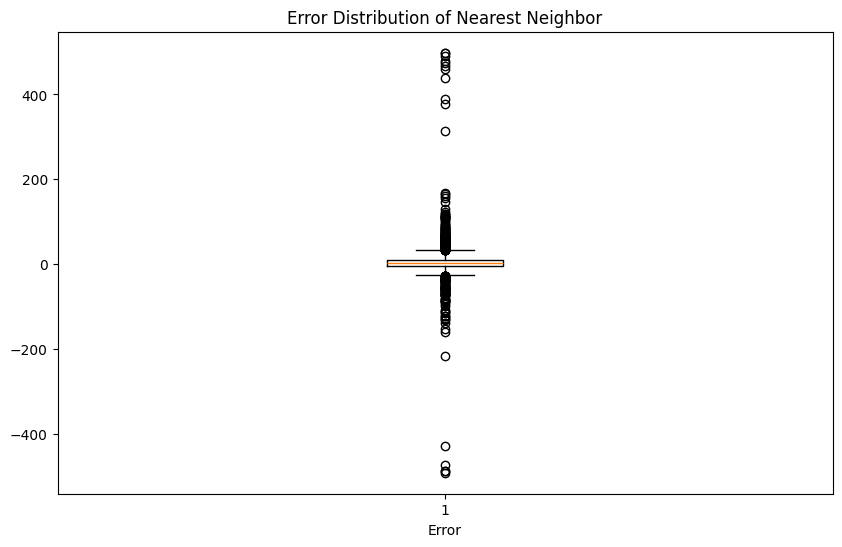

In [21]:
plt.figure(figsize=(10, 6))
plt.boxplot(nearest_neighbor_error_df['error'])
plt.title('Error Distribution of Nearest Neighbor')
plt.xlabel('Error')
plt.show()

In [22]:
get_quantile_table(nearest_neighbor_error_df)

,Quantile,Value
0.03,0.03,-55.257744
0.10,0.10,-15.380208
0.25,0.25,-4.646875
0.50,0.50,1.541667
0.75,0.75,10.575517
0.90,0.90,30.463542
0.97,0.97,70.063237


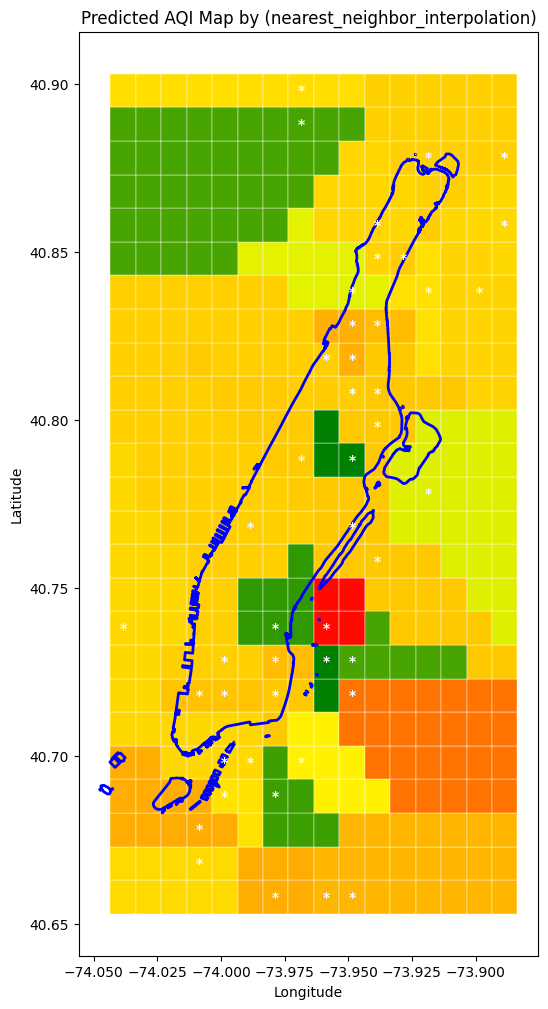

In [23]:
plot_interpolated_grid(nearest_neighbor_interpolation)

Lagrange

In [24]:
from scipy.interpolate import lagrange

In [25]:
def lagrange_interpolation(data):
    
    data = np.array(data, dtype=np.float64)

    rows, cols = data.shape

    filled_data = np.copy(data)

    def interpolate(arr):
        known_indices = np.where(~np.isnan(arr))[0]
        known_values = arr[known_indices]
        
        if len(known_indices) < 2:
            return arr

        poly = lagrange(known_indices, known_values)

        missing_indices = np.where(np.isnan(arr))[0]
        arr[missing_indices] = poly(missing_indices)
        
        return arr

    for i in range(rows):
        filled_data[i, :] = interpolate(filled_data[i, :])

    for j in range(cols):
        filled_data[:, j] = interpolate(filled_data[:, j])

    filled_data[filled_data < 0] = 0
    filled_data[filled_data > 300] = 300

    return filled_data.tolist()

In [26]:
filled_values = lagrange_interpolation(values)
print(filled_values)

[[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]


In [27]:
lagrange_error_df = experiment(lagrange_interpolation)
lagrange_error_df['error'].std()

104.78571131601201

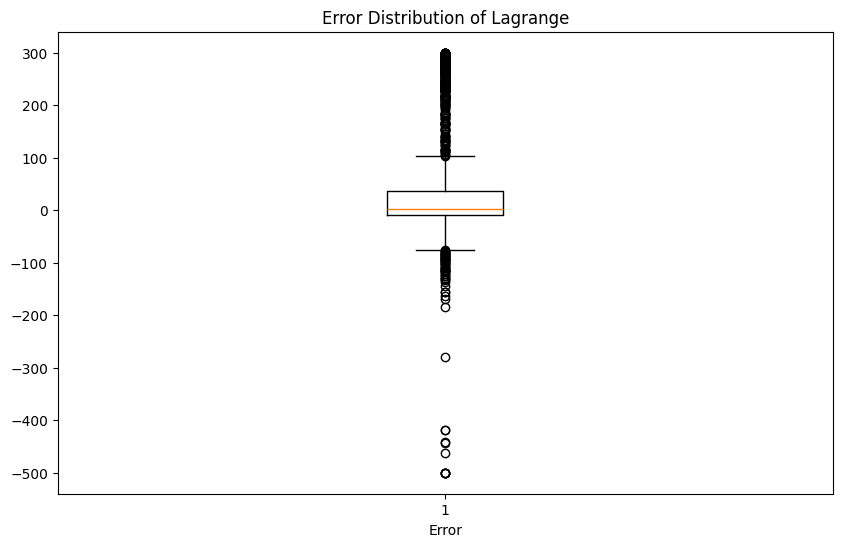

In [28]:
plt.figure(figsize=(10, 6))
plt.boxplot(lagrange_error_df['error'])
plt.title('Error Distribution of Lagrange')
plt.xlabel('Error')
plt.show()

In [29]:
get_quantile_table(lagrange_error_df)

,Quantile,Value
0.03,0.03,-87.843436
0.10,0.10,-40.953333
0.25,0.25,-8.927126
0.50,0.50,2.360618
0.75,0.75,35.819179
0.90,0.90,233.703798
0.97,0.97,287.658854


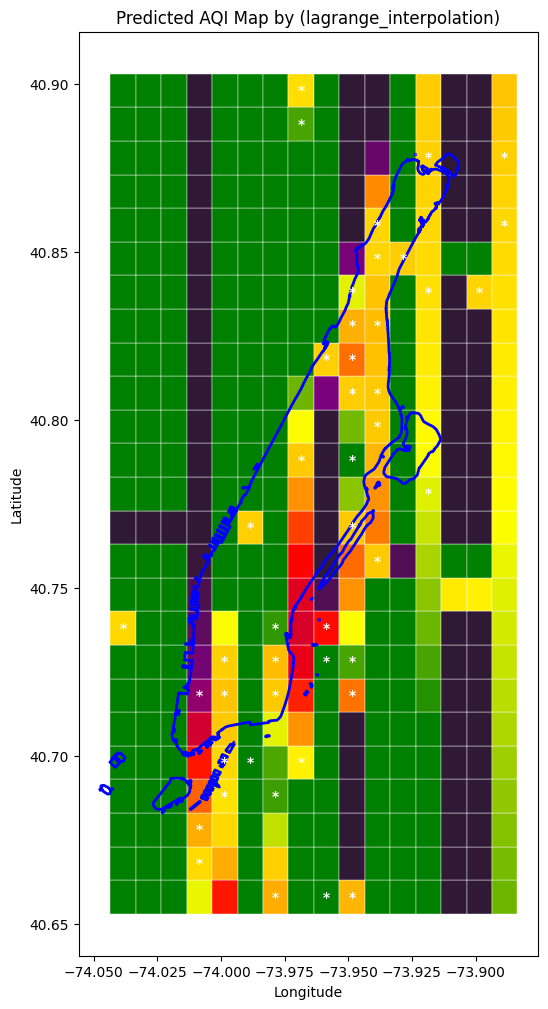

In [30]:
plot_interpolated_grid(lagrange_interpolation)

Gaussian Process

In [31]:
import warnings
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
warnings.filterwarnings("ignore", category=UserWarning)

In [32]:
def gaussian_process_interpolation(data):
    
    data = np.array(data, dtype=np.float64)
    rows, cols = data.shape

    x = np.arange(rows)
    y = np.arange(cols)
    
    known_points = ~np.isnan(data)
    points = np.array([(i, j) for i in range(rows) for j in range(cols) if known_points[i, j]])
    values = data[known_points]

    if len(points) < 2:
        return data.tolist()

    kernel = C(1.0, (1e-4, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e3))

    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

    gp.fit(points, values)

    all_points = np.array([(i, j) for i in range(rows) for j in range(cols)])
    interpolated_values, _ = gp.predict(all_points, return_std=True)

    interpolated_data = np.full(data.shape, np.nan)
    for (i, j), value in zip(all_points, interpolated_values):
        interpolated_data[i, j] = value

    interpolated_data[interpolated_data < 0] = 0

    return interpolated_data.tolist()

In [33]:
filled_values = gaussian_process_interpolation(values)
print(filled_values)

[[1.0149507275664291, 2.0049915362213255, 2.9925024901158963], [3.999999999999716, 5.0050066798365265, 6.000000000119485], [6.982509466515978, 8.00000000003962, 8.999999999840043]]


In [34]:
gaussian_process_error_df = experiment(gaussian_process_interpolation)
gaussian_process_error_df['error'].std()

47.74095621574892

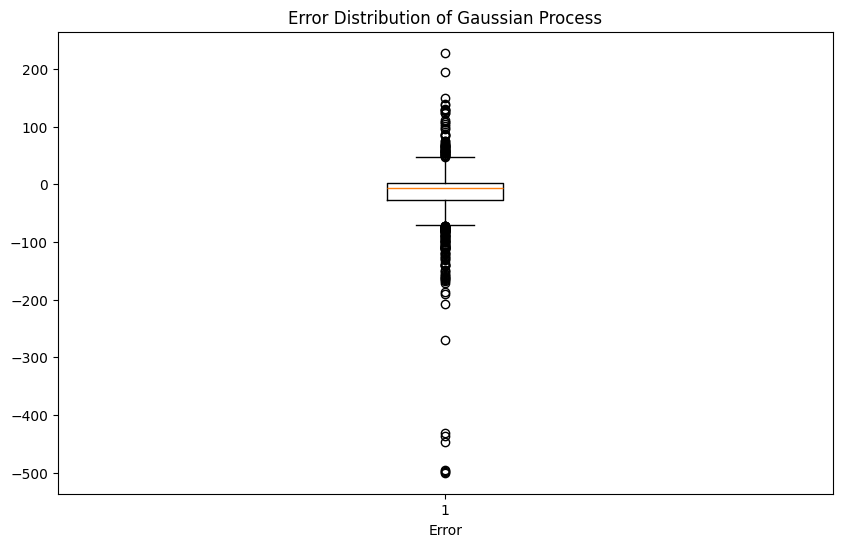

In [35]:
plt.figure(figsize=(10, 6))
plt.boxplot(gaussian_process_error_df['error'])
plt.title('Error Distribution of Gaussian Process')
plt.xlabel('Error')
plt.show()

In [36]:
get_quantile_table(gaussian_process_error_df)

,Quantile,Value
0.03,0.03,-103.357735
0.10,0.10,-58.890878
0.25,0.25,-27.366810
0.50,0.50,-6.837500
0.75,0.75,2.495833
0.90,0.90,20.628070
0.97,0.97,50.454585


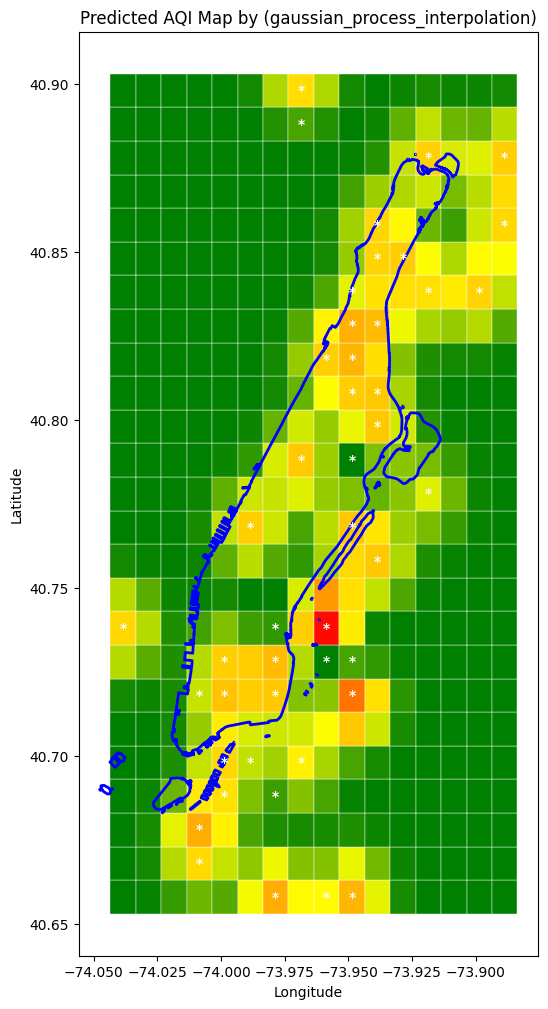

In [37]:
plot_interpolated_grid(gaussian_process_interpolation)

IDM

In [38]:
from inverse_distance_weighted import idm_interpolate

In [39]:
idm_error_df = experiment(idm_interpolate)
idm_error_df['error'].std()

37.59412142695583

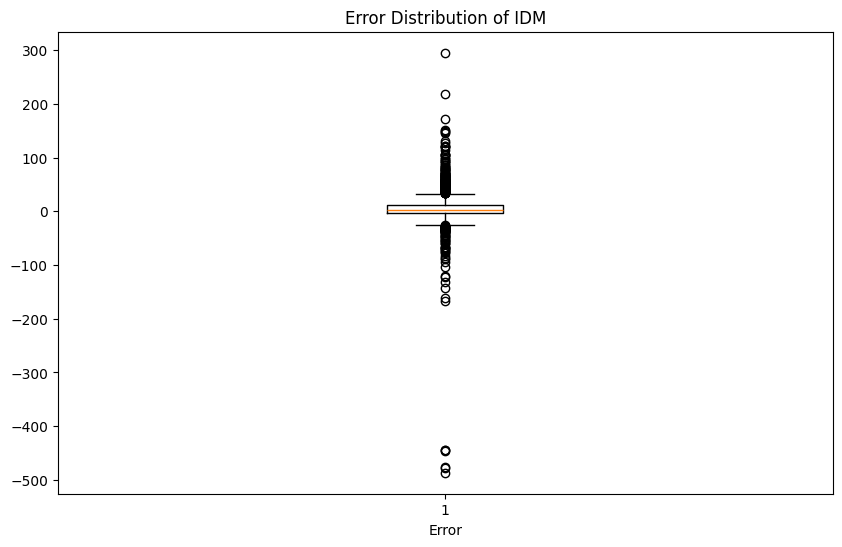

In [40]:
plt.figure(figsize=(10, 6))
plt.boxplot(idm_error_df['error'])
plt.title('Error Distribution of IDM')
plt.xlabel('Error')
plt.show()

In [41]:
get_quantile_table(idm_error_df)

,Quantile,Value
0.03,0.03,-32.958054
0.10,0.10,-13.312500
0.25,0.25,-3.555364
0.50,0.50,2.572917
0.75,0.75,11.145269
0.90,0.90,26.886670
0.97,0.97,62.427526


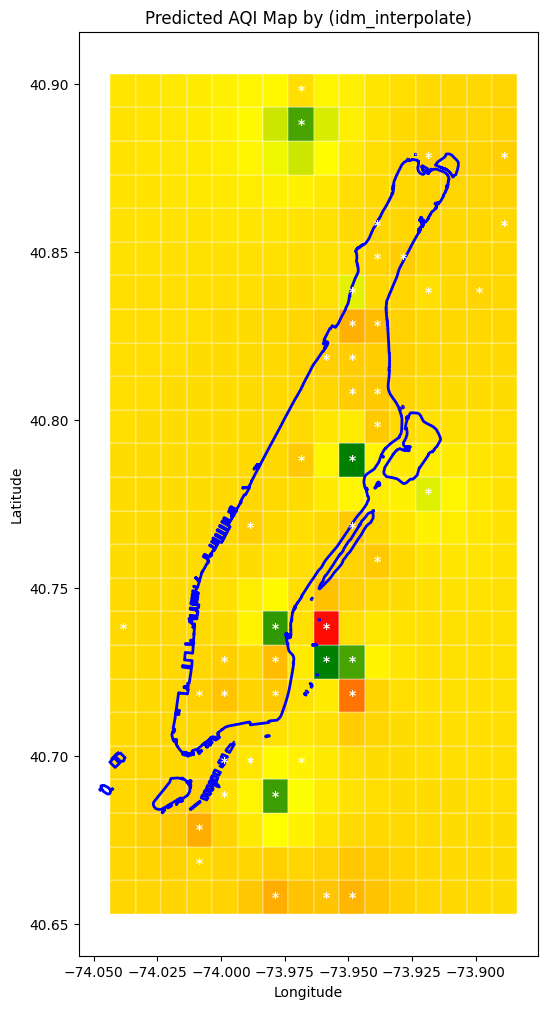

In [42]:
plot_interpolated_grid(idm_interpolate)

Intensify the impact of the nearest sensor

In [43]:
from inverse_distance_nearest_intensified import idm_interpolate_nearest_intensified

In [44]:
idm_nt_error_df = experiment(idm_interpolate_nearest_intensified)
idm_nt_error_df['error'].std()

45.860177417299056

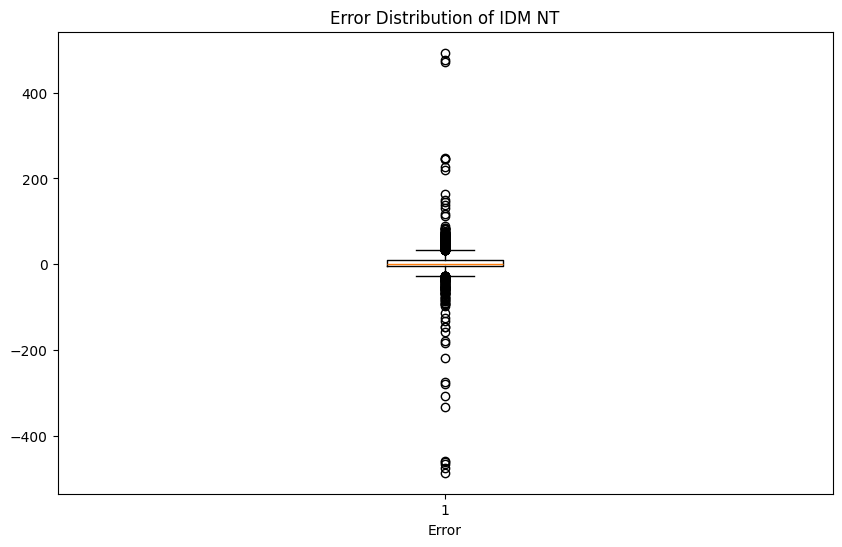

In [45]:
plt.figure(figsize=(10, 6))
plt.boxplot(idm_nt_error_df['error'])
plt.title('Error Distribution of IDM NT')
plt.xlabel('Error')
plt.show()

In [46]:
get_quantile_table(idm_nt_error_df)

,Quantile,Value
0.03,0.03,-53.643253
0.10,0.10,-14.508330
0.25,0.25,-4.492064
0.50,0.50,1.297917
0.75,0.75,10.415129
0.90,0.90,29.879362
0.97,0.97,60.609294


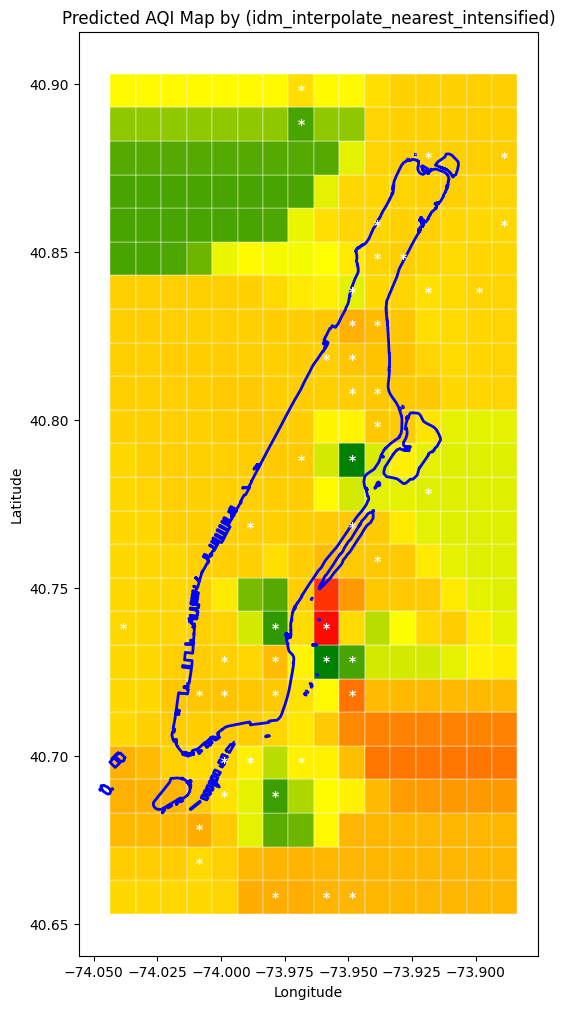

In [47]:
plot_interpolated_grid(idm_interpolate_nearest_intensified)

Average

In [48]:
from simple_average import simple_average_interpolate

In [49]:
avg_error_df = experiment(simple_average_interpolate)
avg_error_df['error'].std()

45.90590189515852

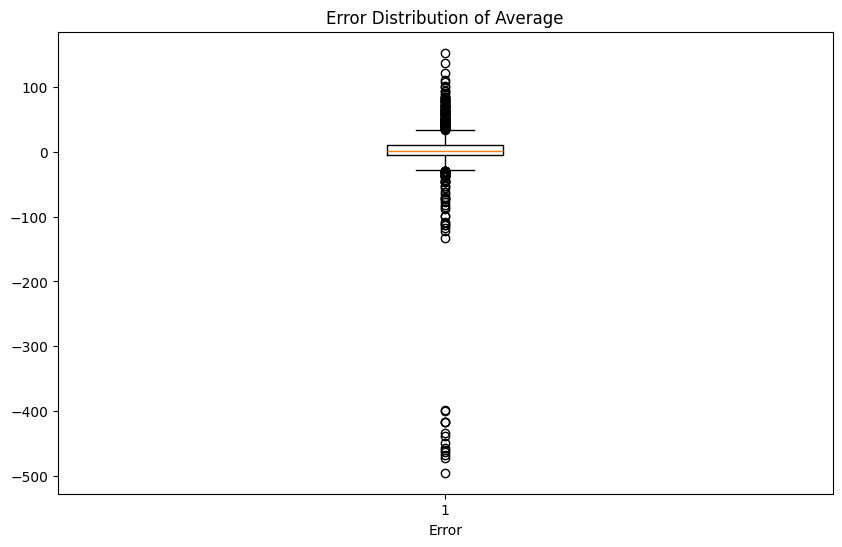

In [50]:
plt.figure(figsize=(10, 6))
plt.boxplot(avg_error_df['error'])
plt.title('Error Distribution of Average')
plt.xlabel('Error')
plt.show()

In [51]:
get_quantile_table(avg_error_df)

,Quantile,Value
0.03,0.03,-31.828774
0.10,0.10,-14.977297
0.25,0.25,-5.386124
0.50,0.50,1.695472
0.75,0.75,10.325208
0.90,0.90,26.029205
0.97,0.97,58.508463


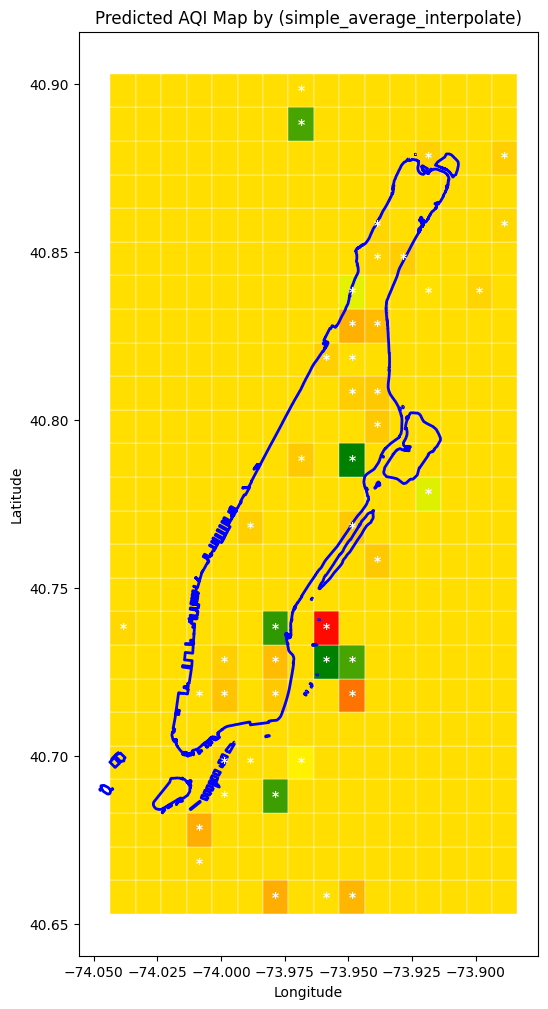

In [52]:
plot_interpolated_grid(simple_average_interpolate)

Let's put them together.

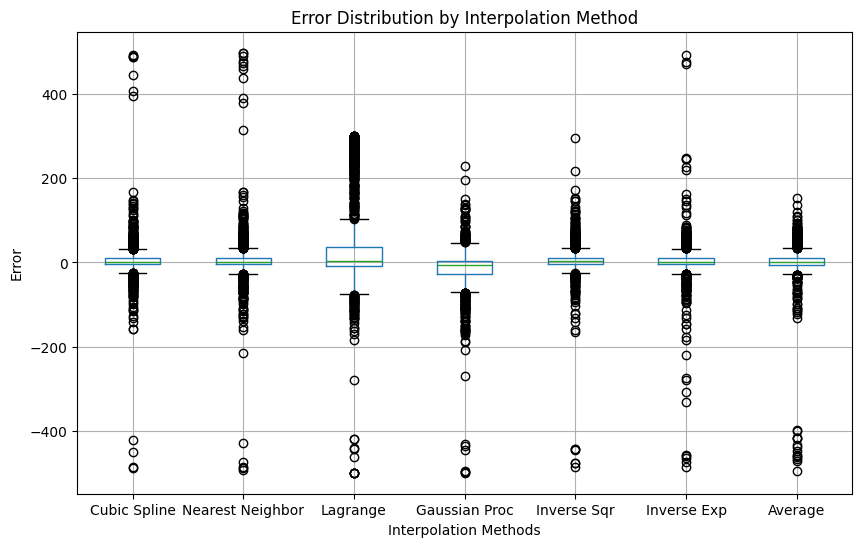

In [53]:
error_data = pd.DataFrame({
    'Cubic Spline': cubic_spline_error_df['error'],
    'Nearest Neighbor': nearest_neighbor_error_df['error'],
    'Lagrange': lagrange_error_df['error'],
    'Gaussian Proc': gaussian_process_error_df['error'],
    'Inverse Sqr': idm_error_df['error'],
    'Inverse Exp': idm_nt_error_df['error'],
    'Average': avg_error_df['error']
})

plt.figure(figsize=(10, 6))
error_data.boxplot()
plt.title('Error Distribution by Interpolation Method')
plt.xlabel('Interpolation Methods')
plt.ylabel('Error')
plt.show()

Finally choose IDM. Cubic Spline is also good.